<a href="https://colab.research.google.com/github/ndb796/PyTorch-CNN/blob/main/PyTorch_CNN_AlexNet_CIFAR10_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **CIFAR10 Dataset**

* 작성자: 나동빈(Dongbin Na)
* 본 코드는 POSTECH의 **CSED703G 수업** 과제로 작성한 코드입니다.
* CNN을 이용해 CIFAR10 데이터셋에 대하여 학습/평가를 진행합니다.
* 코드 실행 전에 **[런타임]** → **[런타임 유형 변경]** → 유형을 **GPU**로 설정해야 합니다.

#### 필요한 라이브러리 불러오기

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from matplotlib import pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np
import os

device = 'cuda'

#### 데이터셋(Dataset) 다운로드 및 불러오기

In [ ]:
import torchvision
import torchvision.transforms as transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# 일반적으로 많이 사용되는 입력 전처리(preprocessing) 테크닉
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), # 패딩 이후 랜덤하게 잘라서 뽑기
    transforms.RandomHorizontalFlip(), # 좌우 반전 (MNIST 말고 CIFAR10에서는 효과적)
    transforms.ToTensor(),
    normalize, # 실험 결과, 입력 정규화(input normalization)가 성능에 크게 영향을 미치지는 않음
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize,
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=4)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


#### 학습(Training) 및 평가(Testing) 함수 정의

In [ ]:
def train(net, epoch, optimizer, criterion, train_loader):
    print('[ Train epoch: %d ]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        benign_outputs = net(inputs)
        loss = criterion(benign_outputs, targets)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, predicted = benign_outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print('Train accuarcy:', 100. * correct / total)
    print('Train average loss:', train_loss / total)
    return (100. * correct / total, train_loss / total)


def evaluate(net, epoch, file_name, data_loader, info):
    print('[ Evaluate epoch: %d ]' % epoch)
    print("Dataset:", info)

    net.eval() # Dropout을 적용하는 경우 필수임
    test_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(data_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        total += targets.size(0)

        outputs = net(inputs)
        test_loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()

    print('Accuarcy:', 100. * correct / total)
    print('Average loss:', test_loss / total)
    return (100. * correct / total, test_loss / total)

#### 혼동행렬(Confusion Matrix) 함수 정의

* 학습이 완료된 모델을 불러와 혼동 행렬을 NumPy 객체로 반환합니다.
* 별도로 데이터 로더(data loader)를 파라미터로 이용해 해당 데이터셋에 대하여 평가를 진행합니다.

In [ ]:
def get_confusion_matrix(net, num_classes, data_loader):
    confusion_matrix = torch.zeros(num_classes, num_classes)

    net.eval() # Dropout을 적용하는 경우 필수임

    for batch_idx, (inputs, targets) in enumerate(data_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = net(inputs)
        _, predicted = outputs.max(1)

        for t, p in zip(targets.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

    return confusion_matrix

#### AlexNet 모델 정의

* **과제에서 명시하고** 있는 AlexNet 모델 아키텍처는 다음과 같습니다.
  * PyTorch가 공식적으로 제공하는 AlexNet 아키텍처와 차이가 있습니다.
* PyTorch 공식 AlexNet 코드를 참고하여 아래 아키텍처에 맞게 변형했습니다.

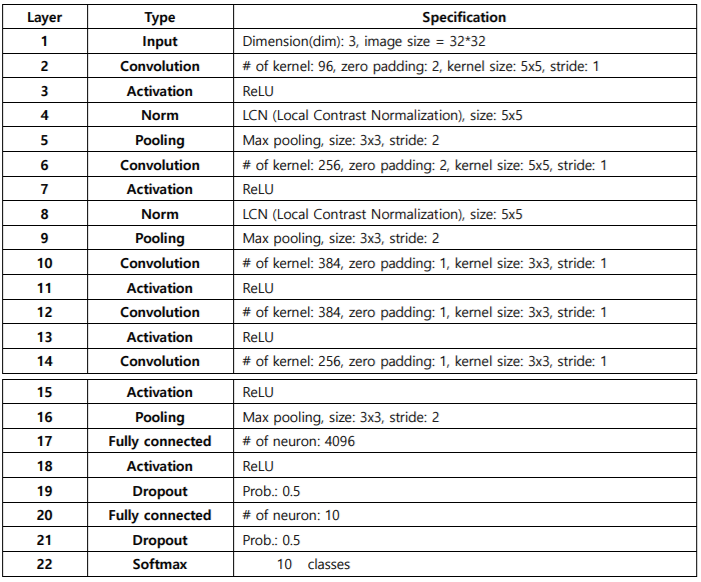

In [ ]:
class LocalResponseNorm(nn.Module):
    def __init__(self, size, alpha = 1e-4, beta = 0.75, k = 1.0):
        super(LocalResponseNorm, self).__init__()
        self.size = size
        self.alpha = alpha
        self.beta = beta
        self.k = k

    def forward(self, input):
        return F.local_response_norm(input, self.size, self.alpha, self.beta, self.k)

In [ ]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            # 여기에서 (3 x 32 x 32)
            # 입력 채널: 3, 출력 채널: 96 (커널 96개)
            nn.Conv2d(3, 96, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            LocalResponseNorm(size=5),
            # 여기에서 (96 x 32 x 32)
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 여기에서 (96 x 15 x 15)
            # 입력 채널: 96, 출력 채널: 256 (커널 256개)
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            LocalResponseNorm(size=5),
            # 여기에서 (256 x 15 x 15)
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 여기에서 (256 x 7 x 7)
            # 입력 채널: 256, 출력 채널: 384 (커널 384개)
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            # 여기에서 (384 x 7 x 7)
            nn.ReLU(inplace=True),
            # 입력 채널: 384, 출력 채널: 384 (커널 384개)
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            # 여기에서 (384 x 7 x 7)
            nn.ReLU(inplace=True),
            # 입력 채널: 384, 출력 채널: 384 (커널 384개)
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            # 여기에서 (384 x 7 x 7)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 여기에서 (384 x 3 x 3)
        )
        self.classifier = nn.Sequential(
            nn.Linear(384 * 3 * 3, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 10),
            nn.Dropout(),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

#### 결과 확인: AlexNet 결과 분석

In [ ]:
# 학습 과정 중에 천천히 학습률(learning rate) 감소 시키기
def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 100:
        lr /= 10
    if epoch >= 150:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


net = AlexNet()
net = net.to(device)

epoch = 200
learning_rate = 0.1
file_name = "AlexNet_CIFAR10.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
test_result = []

train_result.append(evaluate(net, 0, file_name, train_loader, "Train"))
test_result.append(evaluate(net, 0, file_name, test_loader, "Test"))

for i in range(epoch):
    adjust_learning_rate(optimizer, epoch)
    train(net, i, optimizer, criterion, train_loader)
    train_acc, train_loss = evaluate(net, i + 1, file_name, train_loader, "Train")
    test_acc, test_loss = evaluate(net, i + 1, file_name, test_loader, "Test")

    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved!')

    train_result.append((train_acc, train_loss))
    test_result.append((test_acc, test_loss))

[ Evaluate epoch: 0 ]
Dataset: Train
Accuarcy: 10.0
Average loss: 0.018007904171943666
[ Evaluate epoch: 0 ]
Dataset: Test
Accuarcy: 10.0
Average loss: 0.02302759642601013
[ Train epoch: 0 ]
Train accuarcy: 12.756
Train average loss: 0.017898763394355775
[ Evaluate epoch: 1 ]
Dataset: Train
Accuarcy: 23.524
Average loss: 0.017482829942703247
[ Evaluate epoch: 1 ]
Dataset: Test
Accuarcy: 24.59
Average loss: 0.022303612565994262
Model Saved!
[ Train epoch: 1 ]
Train accuarcy: 19.352
Train average loss: 0.016991372556686403
[ Evaluate epoch: 2 ]
Dataset: Train
Accuarcy: 27.972
Average loss: 0.01585622535228729
[ Evaluate epoch: 2 ]
Dataset: Test
Accuarcy: 29.74
Average loss: 0.02007484841346741
Model Saved!
[ Train epoch: 2 ]
Train accuarcy: 23.346
Train average loss: 0.016230194561481476
[ Evaluate epoch: 3 ]
Dataset: Train
Accuarcy: 33.42
Average loss: 0.014945399889945983
[ Evaluate epoch: 3 ]
Dataset: Test
Accuarcy: 34.98
Average loss: 0.018870477545261385
Model Saved!
[ Train epoch: 

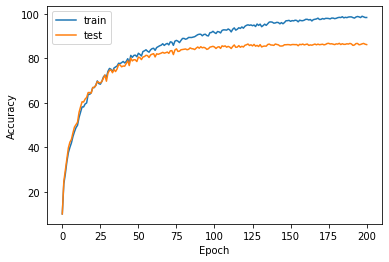

In [ ]:
# 정확도(accuracy) 커브 시각화
plt.plot([i for i in range(epoch + 1)], [i[0] for i in train_result])
plt.plot([i for i in range(epoch + 1)], [i[0] for i in test_result])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "test"])
plt.show()

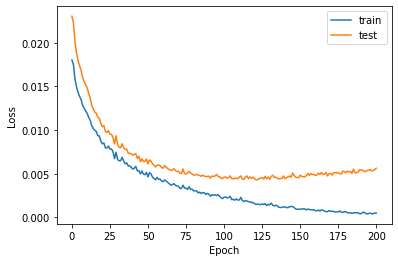

In [ ]:
# 손실(loss) 커브 시각화
plt.plot([i for i in range(epoch + 1)], [i[1] for i in train_result])
plt.plot([i for i in range(epoch + 1)], [i[1] for i in test_result])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "test"])
plt.show()

[ 각 클래스당 데이터 개수 ]
tensor([5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000.])
[ 혼동 행렬(confusion matrix) 시각화 ]


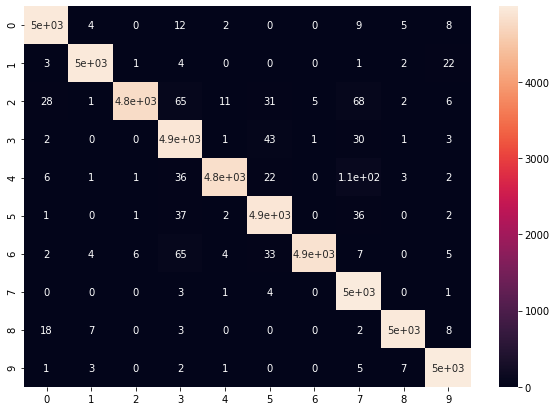

[ 각 클래스에 따른 정확도 ]
tensor([0.9920, 0.9934, 0.9566, 0.9838, 0.9642, 0.9842, 0.9748, 0.9982, 0.9924,
        0.9962])
[ 전체 평균 정확도 ]
tensor(0.9836)


In [ ]:
# 혼동 행렬(Confusion Matrix) 시각화 (학습 데이터셋)
net = AlexNet()
net = net.to(device)

file_name = "./checkpoint/AlexNet_CIFAR10.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

confusion_matrix = get_confusion_matrix(net, 10, train_loader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
# 행(row)은 실제 레이블, 열(column)은 모델이 분류한 레이블
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(10)], columns = [i for i in range(10)])
plt.figure(figsize = (10, 7))
sn.heatmap(res, annot=True)
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

[ 각 클래스당 데이터 개수 ]
tensor([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.])
[ 혼동 행렬(confusion matrix) 시각화 ]


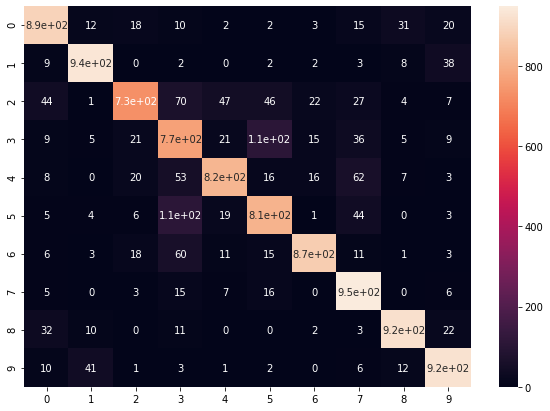

[ 각 클래스에 따른 정확도 ]
tensor([0.8870, 0.9360, 0.7320, 0.7700, 0.8150, 0.8100, 0.8720, 0.9480, 0.9200,
        0.9240])
[ 전체 평균 정확도 ]
tensor(0.8614)


In [ ]:
# 혼동 행렬(Confusion Matrix) 시각화 (테스트 데이터셋)
net = AlexNet()
net = net.to(device)

file_name = "./checkpoint/AlexNet_CIFAR10.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

confusion_matrix = get_confusion_matrix(net, 10, test_loader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
# 행(row)은 실제 레이블, 열(column)은 모델이 분류한 레이블
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(10)], columns = [i for i in range(10)])
plt.figure(figsize = (10, 7))
sn.heatmap(res, annot=True)
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

In [ ]:
from google.colab import files

In [ ]:
files.download('./checkpoint/AlexNet_CIFAR10.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>